In [17]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from functools import reduce

%matplotlib inline

In [4]:
# IMPORT DATA
df = pd.read_csv('Base_ATER.csv', index_col=0)

# SELECT AREAS WITH COMPLETED ISOLATION WORKS ONLY
df['Concluded_Isolation'] = df.loc[:, 'Concluded_Isolation'].astype('category')
df_Iso = df[(df['Isolation'] == 'CONCLUIDO') | (df['Concluded_Isolation'] == 1)].reset_index(drop=True)

# DROP A FEW COLUMNS WE WON'T USE
df_Iso.drop(['COD_PLA', 'Farm', 'Num_Visits', 'GLEBA', 'LINHA', 'KM', 'LOTE'], axis=1, inplace=True)

# FILL MISSING DATA
materials = ['Piles', 'Columns', 'Tensioners', 'Wire_rolls', 'Carbonate']
seedlings = ['Seedlings_APP','Seedlings_RL']
areas = ['APP_Area', 'RL_Area', 'Total_Area']

df_Iso[materials] = df_Iso[materials].fillna(0).astype(float)
df_Iso[areas] = df_Iso[areas].fillna(0).astype(float)
df_Iso = df_Iso[df_Iso['Total_Area'] > 0] #Removes problematic rows with area = 0
df_Iso.reset_index(drop=True, inplace=True)


# TRANSLATIONS
activities = {
        'BOVINOCULTURA DE LEITE':'Dairy cattle',
        'BOVINOCULTURA DE CORTE':'Beef cattle',
        'BOVINOCULTURA MISTA':'Mixed cattle',
        'CAFEICULTURA':'Coffee cultivation',
        'LAVOURA':'Agriculture',
        'PISCICULTURA':'Fish farming',
        'FRUTICULTURA':'Fruit growing', 'FRUTICULTURA*':'Fruit growing',
        'HORTICULTURA':'Horticulture',
        'AGROINDUSTRIA':'Agroindustry',
        'ARRENDAMENTO':'Lease',
        'GRANJA AVICOLA':'Poultry',
        'GRANJA SUINA':'Pork',
        'SABOARIA':'Soap production',
        'OLERICULTURA':'Olericulture'
        }

df_Iso[['Main_Activity', 'Secondary_Activity']] = df_Iso[['Main_Activity', 'Secondary_Activity']].replace(activities)
df_Iso['Secondary_Activity'].fillna('None', inplace=True)

df_Iso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   COD_PRO              271 non-null    object  
 1   X_UTM                271 non-null    float64 
 2   Y_UTM                271 non-null    float64 
 3   County               271 non-null    object  
 4   ASSOCIAÇÃO / STTR    269 non-null    object  
 5   Main_Activity        271 non-null    object  
 6   Secondary_Activity   271 non-null    object  
 7   Piles                271 non-null    float64 
 8   Columns              271 non-null    float64 
 9   Tensioners           271 non-null    float64 
 10  Wire_rolls           271 non-null    float64 
 11  Isolation            270 non-null    object  
 12  Carbonate            271 non-null    float64 
 13  APP_Area             271 non-null    float64 
 14  RL_Area              271 non-null    float64 
 15  Total_Area           27

## Linear correlations

In [5]:
display(df_Iso.corr().loc[:, materials])

,Piles,Columns,Tensioners,Wire_rolls,Carbonate
X_UTM,0.095524,0.074675,-0.109773,0.070775,0.012541
Y_UTM,-0.152406,-0.197652,-0.016702,-0.142722,0.036669
Piles,1.000000,0.798457,0.407317,0.874271,0.058548
Columns,0.798457,1.000000,0.422008,0.742656,0.034301
Tensioners,0.407317,0.422008,1.000000,0.404439,0.074108
Wire_rolls,0.874271,0.742656,0.404439,1.000000,0.229997
Carbonate,0.058548,0.034301,0.074108,0.229997,1.000000
APP_Area,0.404129,0.258891,0.143232,0.393069,0.085386
RL_Area,0.148271,0.175701,0.119119,0.105171,-0.052531
Total_Area,0.050118,0.015548,-0.053298,0.061706,-0.009358


INTERESTING RESULTS:

- correlations between different materials, as expected

- Largest correlation with areas: (both quite low)
 - APP_Area and Piles (0.40)
 - APP_Area and Wire_rolls (0.39)
 
 
Why isn't the same tue for RL? Is the land type (RL, APP) determined by
features not displayed above (topography, soil type, p.H. etc.) due to
their exploitation rules?
Significant correlation between seedlings and Piles, Wire_rolls
Questions: how is a fence built? how is the amount of seedlings estimated?

In [6]:
# FOCUS ON AREAS AND METERIALS, SEEDLINGS
display(df_Iso.corr().loc[areas, seedlings + materials])

,Seedlings_APP,Seedlings_RL,Piles,Columns,Tensioners,Wire_rolls,Carbonate
APP_Area,0.434841,0.018263,0.404129,0.258891,0.143232,0.393069,0.085386
RL_Area,0.037271,0.359161,0.148271,0.175701,0.119119,0.105171,-0.052531
Total_Area,0.034074,-0.105889,0.050118,0.015548,-0.053298,0.061706,-0.009358


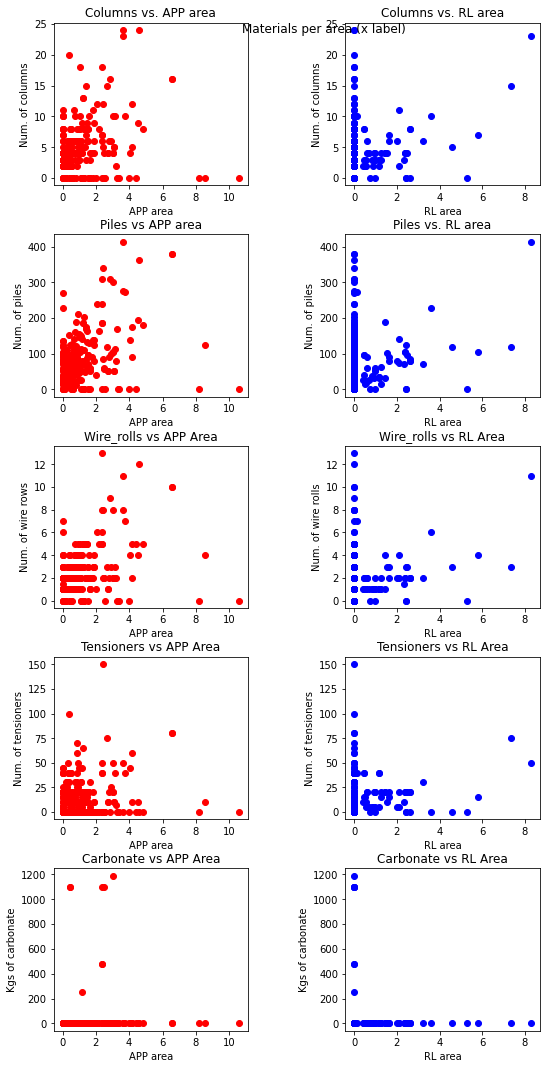

In [28]:
# MATERIALS PER TYPE OF LAND USE (RL AND APP)
# Very inefficient way of doing so many plots
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10))
fig.subplots_adjust(wspace=0.5, hspace=0.3, left=0.125, right=0.8, top=1.5, bottom=0.1)
fig.suptitle('Materials per area (x label)', y=1.5)

ax[0,0].scatter(y='Columns', x='APP_Area', data=df_Iso, color='r')
ax[0,0].set_title('Columns vs. APP area')
ax[0,0].set_ylabel('Num. of columns')
ax[0,0].set_xlabel('APP area')

ax[0,1].scatter(y='Columns', x='RL_Area', data=df_Iso, color='b')
ax[0,1].set_title('Columns vs. RL area')
ax[0,1].set_ylabel('Num. of columns')
ax[0,1].set_xlabel('RL area')

ax[1,0].scatter(y='Piles', x='APP_Area', data=df_Iso, color='r')
ax[1,0].set_title('Piles vs APP area')
ax[1,0].set_ylabel('Num. of piles')
ax[1,0].set_xlabel('APP area')

ax[1,1].scatter(y='Piles', x='RL_Area', data=df_Iso, color='b')
ax[1,1].set_title('Piles vs. RL area')
ax[1,1].set_ylabel('Num. of piles')
ax[1,1].set_xlabel('RL area')

ax[2,0].scatter(y='Wire_rolls', x='APP_Area', data=df_Iso, color='r')
ax[2,0].set_title('Wire_rolls vs APP Area')
ax[2,0].set_ylabel('Num. of wire rows')
ax[2,0].set_xlabel('APP area')

ax[2,1].scatter(y='Wire_rolls', x='RL_Area', data=df_Iso, color='b')
ax[2,1].set_title('Wire_rolls vs RL Area')
ax[2,1].set_ylabel('Num. of wire rolls')
ax[2,1].set_xlabel('RL area')

ax[3,0].scatter(y='Tensioners', x='APP_Area', data=df_Iso, color='r')
ax[3,0].set_title('Tensioners vs APP Area')
ax[3,0].set_ylabel('Num. of tensioners')
ax[3,0].set_xlabel('APP area')


ax[3,1].scatter(y='Tensioners', x='RL_Area', data=df_Iso, color='b')
ax[3,1].set_title('Tensioners vs RL Area')
ax[3,1].set_ylabel('Num. of tensioners')
ax[3,1].set_xlabel('RL area')

ax[4,0].scatter(y='Carbonate', x='APP_Area', data=df_Iso, color='r')
ax[4,0].set_title('Carbonate vs APP Area')
ax[4,0].set_ylabel('Kgs of carbonate')
ax[4,0].set_xlabel('APP area')

ax[4,1].scatter(y='Carbonate', x='RL_Area', data=df_Iso, color='b')
ax[4,1].set_title('Carbonate vs RL Area')
ax[4,1].set_ylabel('Kgs of carbonate')
ax[4,1].set_xlabel('RL area')

plt.show()

There is a peak of materials used in null areas. This may be bacause the value of each material in the dataframe might refer to the total amount used in each farm. That is, a farm may have both a RL and a separate APP area, and the values fior carbonate and fence materials may refer to the total amount of each material employed in the farm. 

This is probably affecting the correlation analysis and thus we should separate such cases.

In [41]:
display('APP areas', df_Iso[df_Iso['APP_Area'] > 0].corr().loc['APP_Area', materials+seedlings])
display('RL areas', df_Iso[df_Iso['RL_Area'] > 0].corr().loc['RL_Area', materials+seedlings])

'APP areas'

Piles            0.426895
Columns          0.271389
Tensioners       0.161869
Wire_rolls       0.402545
Carbonate        0.067839
Seedlings_APP    0.464255
Seedlings_RL     0.133392
Name: APP_Area, dtype: float64

'RL areas'

Piles            0.494788
Columns          0.568100
Tensioners       0.281075
Wire_rolls       0.516515
Carbonate       -0.002282
Seedlings_APP    0.577618
Seedlings_RL     0.105638
Name: RL_Area, dtype: float64

Separating the materials in the areas increase significantly the correlations as we exclude the left peak of points in the plots.

We thus conclude that any analysis of Total_Area is of little or no meaning, and RL and APP areas ought to be considered separately.

## Polynomial correlations

In [39]:
df_IsoLog = df_Iso.apply(lambda x : np.log(x + 0.00001) if x.name in areas else x)
display(df_IsoLog.corr().loc[:, materials])

,Piles,Columns,Tensioners,Wire_rolls,Carbonate
X_UTM,0.095524,0.074675,-0.109773,0.070775,0.012541
Y_UTM,-0.152406,-0.197652,-0.016702,-0.142722,0.036669
Piles,1.000000,0.798457,0.407317,0.874271,0.058548
Columns,0.798457,1.000000,0.422008,0.742656,0.034301
Tensioners,0.407317,0.422008,1.000000,0.404439,0.074108
Wire_rolls,0.874271,0.742656,0.404439,1.000000,0.229997
Carbonate,0.058548,0.034301,0.074108,0.229997,1.000000
APP_Area,0.174281,0.122295,0.030769,0.196211,0.090490
RL_Area,0.008447,0.022888,0.073198,-0.043322,-0.073112
Total_Area,0.133854,0.055071,-0.014775,0.131583,0.016112


Added 0.00001 because I got a divided by zero error message:
```
679: RuntimeWarning: divide by zero encountered in log
result = getattr(ufunc, method)(*inputs, **kwargs)
```
This should not be a significant problem due to the logarithm fct slow growth

In [40]:
# Focusing again on areas:
display('APP areas', df_IsoLog[df_IsoLog['APP_Area'] > 0].corr().loc['APP_Area', seedlings + materials])
display('RL areas', df_IsoLog[df_IsoLog['RL_Area'] > 0].corr().loc['RL_Area', seedlings + materials])

'APP areas'

Seedlings_APP    0.318382
Seedlings_RL     0.198573
Piles            0.266208
Columns          0.108044
Tensioners       0.175728
Wire_rolls       0.255650
Carbonate        0.067837
Name: APP_Area, dtype: float64

'RL areas'

Seedlings_APP    0.645770
Seedlings_RL     0.004925
Piles            0.491319
Columns          0.541166
Tensioners       0.221040
Wire_rolls       0.500343
Carbonate       -0.016849
Name: RL_Area, dtype: float64

More intersting and significant polynomial correlations. 

For some reason, the amount of seedlings in an APP area in more correlated to the log of the RL area than with the log of the APP area itself. Something similar happens for the linear correlation.

## Quadractic correlation and perimeter

In [42]:
df_IsoSqrt = df_Iso.apply(lambda x : np.sqrt(x) if x.name in areas else x)
df_IsoSqrt.rename({'APP_Area':'Sqrt_App_Area', 'RL_Area':'Sqrt_RL_Area', \
    'Total_Area':'Sqrt_Total_Area'}, axis=1, inplace=True)

In [44]:
df_IsoSqrt[df_IsoSqrt['Sqrt_App_Area'] > 0].corr().loc['Sqrt_App_Area', materials+ seedlings]
correlations_table = pd.DataFrame({
    'APP area':df_Iso[df_Iso['APP_Area'] > 0].corr().loc['APP_Area', materials+ seedlings].round(2),
    'Log APP area':df_IsoLog[df_IsoLog['APP_Area'] > 0].corr().loc['APP_Area', seedlings + materials].round(2),
    'Sqrt APP area':df_IsoSqrt[df_IsoSqrt['Sqrt_App_Area'] > 0].corr().loc['Sqrt_App_Area', materials+ seedlings].round(2),
    'RL area':df_Iso[df_Iso['RL_Area'] > 0].corr().loc['RL_Area', materials + seedlings].round(2),
    'Log RL area':df_IsoLog[df_IsoLog['RL_Area'] > 0].corr().loc['RL_Area', seedlings + materials].round(2),
    'Sqrt RL area':df_IsoSqrt[df_IsoSqrt['Sqrt_RL_Area'] > 0].corr().loc['Sqrt_RL_Area', materials + seedlings].round(2)
    })
display(correlations_table)

,APP area,Log APP area,Sqrt APP area,RL area,Log RL area,Sqrt RL area
Carbonate,0.07,0.07,0.10,-0.00,-0.02,0.05
Columns,0.27,0.11,0.35,0.57,0.54,0.46
Piles,0.43,0.27,0.50,0.49,0.49,0.41
Seedlings_APP,0.46,0.32,0.53,0.58,0.65,0.48
Seedlings_RL,0.13,0.20,0.18,0.11,0.00,0.18
Tensioners,0.16,0.18,0.19,0.28,0.22,0.17
Wire_rolls,0.40,0.26,0.47,0.52,0.50,0.43


The above table shows the correlation coefficient between each material's value and the area, its logarithim and its square root, for both APP and RL.

We see that all the above materials and seedlings values present a stronger correlation with the perimeter than the area for APP areas, whereas the opposite is true for RL areas. Correlations are still considerably weak but removing zero-area points has significantly incresed them. 

As any further perimeter estimation would present a linear relation with the sqrt of the area. Althoug the value itself would differ from the sqrt of area, the correlation coef with the materials and seedlings would remain unchanged.

## Land use discrimination

In [47]:
dfAct = {}
for area in ['APP_Area', 'RL_Area']:
    materials_activity = {}
    for activity in activities.values():
        materials_activity[activity] = \
        df_Iso[(df_Iso[area] > 0) & \
        ((df_Iso['Main_Activity'] == activity) | (df_Iso['Secondary_Activity'] == activity))]\
        .corr().loc[area, materials+seedlings].round(2)
    dfAct[area] = pd.DataFrame(materials_activity)

display('APP area', dfAct['APP_Area'], 'RL area', dfAct['RL_Area'])

'APP area'

,Dairy cattle,Beef cattle,Mixed cattle,Coffee cultivation,Agriculture,Fish farming,Fruit growing,Horticulture,Agroindustry,Lease,Poultry,Pork,Soap production,Olericulture
Piles,0.22,0.68,0.56,0.50,0.04,0.88,0.86,0.68,0.20,1.00,NaN,NaN,NaN,0.92
Columns,0.09,0.42,0.56,0.42,-0.04,0.90,0.85,0.62,-0.13,0.97,NaN,NaN,NaN,0.72
Tensioners,-0.07,0.54,0.14,-0.04,-0.04,0.56,-0.09,-0.31,-0.10,NaN,NaN,NaN,NaN,-0.26
Wire_rolls,0.24,0.62,0.55,0.44,-0.05,0.87,0.87,0.58,0.09,0.99,NaN,NaN,NaN,0.88
Carbonate,0.02,0.17,0.47,0.06,0.23,0.93,0.27,0.41,-0.26,0.99,NaN,NaN,NaN,0.83
Seedlings_APP,0.08,0.82,0.39,0.75,0.03,0.94,0.32,0.16,1.00,NaN,NaN,NaN,NaN,0.88
Seedlings_RL,0.08,-0.25,NaN,NaN,0.75,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'RL area'

,Dairy cattle,Beef cattle,Mixed cattle,Coffee cultivation,Agriculture,Fish farming,Fruit growing,Horticulture,Agroindustry,Lease,Poultry,Pork,Soap production,Olericulture
Piles,-0.13,0.56,1.0,0.77,0.01,0.97,0.82,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Columns,-0.20,0.41,1.0,0.54,0.71,0.86,0.36,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
Tensioners,-0.27,0.07,1.0,0.08,0.80,0.68,-0.78,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
Wire_rolls,-0.19,0.77,1.0,0.71,-0.01,0.97,0.76,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Carbonate,0.09,-0.17,1.0,-0.22,0.50,0.42,0.14,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Seedlings_APP,-0.47,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seedlings_RL,0.16,-0.38,NaN,0.74,1.00,NaN,-1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above tables show correlations coefficients between areas and materials (rows' index), for each activity presented in the farm. That is, the number 0.22 at row 1, column 1 of the first table means that among dairy cattle farms, the correlation between number of Piles used and the APP area equals 0.22 approximately.

## Next:

Questions to answer and problems to solve:

- Is the land type (RL, APP) determined by features not displayed above (topography, soil type, p.H. etc.) due to exploitation/cultivation rules associated to each one of these legal labels?
- Odd correlations between apparently unrelated materials (wire and carbonate, for instance) may indicate hidden features highly correlated to the variables we'll try to predict.
-  We have a problem: If each line in the dataframe corresponds to a unique reforested poligon, and given that each poligon can be either RL or APP but not both, then how come there are lines with both 'APP_Area' and 'RL_Area' non-null values? In fact,
```
display((df_Iso['APP_Area'][df_Iso['RL_Area'] > 0] == 0).sum())
```
returns 37.